We will do cointegration & unit root tests for all of the selected pairs, and eliminate some of them.

In [1005]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import arch.unitroot as at

### GET ALL TICKERS & PAIRS

In [1006]:
df = pd.read_pickle("pairs_to_download.pkl")

tickers_list = list(df.index.union(df.columns))

x_list = df.index.tolist()
y_list = df.columns.tolist()

pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df.iloc[i,j]>0:
            pairs_list.append((x_list[i], y_list[j]))

print(f"{len(pairs_list)} pairs")
pairs_list

10 pairs


[('AEE', 'DUK'),
 ('AEP', 'CNP'),
 ('AEP', 'VST'),
 ('CMS', 'DUK'),
 ('CNP', 'VST'),
 ('ED', 'VST'),
 ('NRG', 'VST'),
 ('OGE', 'XEL'),
 ('SO', 'VST'),
 ('VST', 'WEC')]

### GET TICKER PRICES

In [1007]:
prices= pd.read_pickle("close_prices.pkl")[tickers_list] 
prices

,AEE,AEP,CMS,CNP,DUK,ED,NRG,OGE,SO,VST,WEC,XEL
Date,,,,,,,,,,,,
2021-10-27 00:00:00-04:00,84.459999,84.300003,60.349998,26.309999,102.760002,75.989998,40.580002,34.049999,62.639999,19.660000,89.970001,63.389999
2021-10-28 00:00:00-04:00,84.809998,84.709999,60.720001,26.290001,102.489998,76.290001,40.860001,34.070000,62.740002,19.850000,90.510002,64.330002
2021-10-29 00:00:00-04:00,84.290001,84.709999,60.349998,26.040001,102.010002,75.400002,39.889999,34.070000,62.320000,19.590000,90.059998,64.589996
2021-11-01 00:00:00-04:00,84.279999,85.129997,60.290001,26.290001,102.309998,76.110001,40.459999,34.669998,62.480000,20.010000,90.339996,64.500000
2021-11-02 00:00:00-04:00,84.330002,85.300003,60.439999,26.190001,102.449997,76.440002,39.540001,34.480000,62.490002,19.870001,90.889999,64.709999
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 00:00:00-04:00,76.620003,83.930000,53.970001,26.600000,87.230003,83.419998,40.720001,34.360001,63.500000,21.520000,85.440002,59.730000
2022-10-21 00:00:00-04:00,77.580002,85.629997,54.430000,27.010000,88.459999,84.870003,42.360001,34.970001,64.500000,21.750000,86.650002,60.900002
2022-10-24 00:00:00-04:00,77.870003,86.000000,54.619999,27.209999,88.690002,84.690002,42.990002,35.029999,64.589996,21.490000,86.760002,61.580002


### TESTS

#### COINTEGRATION TEST

Define a function to loop through the tickers and do a cointegration test for each combination

In [1008]:
def cointegration_test(data, p_value=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    confints = np.zeros((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue
            
            if pvalue < p_value: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))
                if result[2][0]>test_stat:
                    confints[i, j]=0.99 
                elif result[2][1]>test_stat:
                    confints[i, j]=0.95
                elif result[2][2]>test_stat:
                    confints[i, j]=0.90
                else:
                    confints[i, j]=1-pvalue               
    return stats, pvalues, pairs, confints

Perform Test

In [988]:
p_value = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs, confints = cointegration_test(prices,p_value)

HeatMap

remaining 10 pairs from 10


,CNP,DUK,VST,WEC,XEL
AEE,nan,0.95,nan,nan,nan
AEP,0.95,nan,0.95,nan,nan
CMS,nan,0.99,nan,nan,nan
CNP,nan,nan,0.95,nan,nan
ED,nan,nan,0.99,nan,nan
NRG,nan,nan,0.95,nan,nan
OGE,nan,nan,nan,nan,0.90
SO,nan,nan,0.95,nan,nan
VST,nan,nan,nan,0.95,nan


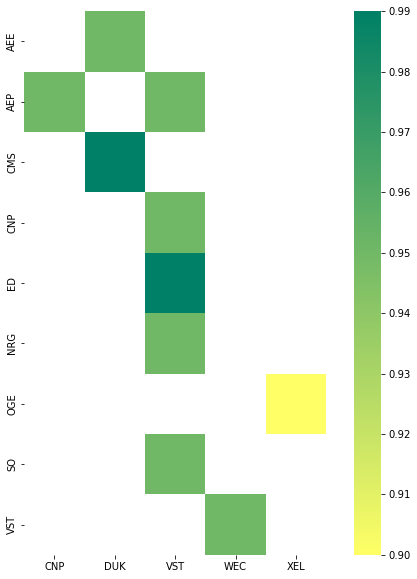

In [990]:
# mask_matrix = (pvalues >= p_value) # possible to increase the level of significance
conf_int = 0.90
mask_matrix = (confints < conf_int) # possible to increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= tickers_list, columns = tickers_list)
pvalues_df = pd.DataFrame(pvalues, index= tickers_list, columns = tickers_list)
confints_df = pd.DataFrame(confints, index= tickers_list, columns = tickers_list)

df_p = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_p = df_p.dropna(how='all')

df_c = confints_df[~mask_df].dropna(how='all', axis=1)
df_c = df_c.dropna(how='all')


def green_apply(x):
    green = {True: "background-color: green", False: "color : white"}
    is_color = (x > 0.95).replace(green)
    return is_color

def yellow_apply(x):
    yellow = {True: "background-color: yellow; color : black"}
    is_color = (x <= 0.95).replace(yellow)
    return is_color

# kept it here although we don't expect to see any red backgroud
def red_apply(x):
    red = {True: "background-color: red;"}
    is_color = (x <= 0.90).replace(red)
    return is_color

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_c,
    xticklabels=df_c.columns,
    yticklabels=df_c.index,
    cmap="summer_r",
    square=True
)

print(f"remaining {df_c.count().sum()} pairs from {len(pairs_list)}")

df_c.style.format(precision=2)\
.apply(green_apply)\
.apply(yellow_apply)\
.apply(red_apply)

#### UNIT ROOT TESTS

Loop through pairs & perform tests:

In [1010]:
df_c_adf = df_c.copy()
df_c_pp = df_c.copy()
hedges ={}

N=90
enable_regression_coef = 0

# get new pairs
x_list = df_c.index.tolist()
y_list = df_c.columns.tolist()

pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df.iloc[i,j]>0:
            pairs_list.append((x_list[i], y_list[j]))

for i in range(len(pairs_list)):
    ticker1, ticker2 = list(pairs_list[i])[0], list(pairs_list[i])[1]
    prices_pair= prices[list(pairs_list[i])]
    
    ###HEDGE###
    
    if N>0:
        Y = prices_pair[ticker2].iloc[-N:]
        X = prices_pair[ticker1].iloc[-N:]
    else:
        Y = prices_pair[ticker2]
        X = prices_pair[ticker1]

    if enable_regression_coef:
        X = sm.add_constant(X)

    model = sm.OLS(Y, X)
    model = model.fit()

    if len(model.params) == 1:
        hedge = round(float(model.params[0]),2)
        alfa = 0
    else:
        hedge = round(float(model.params[1]),2)
        alfa = round(float(model.params[0]),2)
    
    hedges[(ticker1, ticker2)]=hedge
    # print pair equation
    #print(f"EQUATION: {ticker2}={hedge}*{ticker1}{'+' + str(round(alfa,1)) if alfa>0 else ''}")

    ###SPREAD###

    prices_pair_s = prices_pair.copy()
    spread = prices_pair_s['spread'] = prices_pair[ticker2] - hedge * prices_pair[ticker1] - alfa
    
    ###ADF###
    
    adf = adfuller(prices_pair_s.spread, autolag='AIC')
    test_stat_df = adf[0]
    critical_values_df = adf[4]

    if critical_values_df['1%']>test_stat_df:
        df_c_adf.loc[(ticker1,ticker2)]=0.99 
    elif critical_values_df['5%']>test_stat_df:
        df_c_adf.loc[(ticker1,ticker2)]=0.95
    elif critical_values_df['10%']>test_stat_df:
        df_c_adf.loc[(ticker1,ticker2)]=0.90
        
    ###PP###  
          
    pp = at.PhillipsPerron(prices_pair_s.spread, trend='ct', test_type='rho')
    test_stat_pp = pp.stat
    critical_values_pp = pp.critical_values

    if critical_values_pp['1%']>test_stat_pp:
        df_c_pp.loc[(ticker1,ticker2)]=0.99 
    elif critical_values_pp['5%']>test_stat_pp:
        df_c_pp.loc[(ticker1,ticker2)]=0.95
    elif critical_values['10%']>test_stat_pp:
        df_c_pp.loc[(ticker1,ticker2)]=0.90

Heatmap ADF

,CNP,DUK,VST,WEC,XEL
AEE,nan,0.95,nan,nan,nan
AEP,0.99,nan,0.99,nan,nan
CMS,nan,0.99,nan,nan,nan
CNP,nan,nan,0.99,nan,nan
ED,nan,nan,0.99,nan,nan
NRG,nan,nan,0.95,nan,nan
OGE,nan,nan,nan,nan,0.95
SO,nan,nan,0.99,nan,nan
VST,nan,nan,nan,0.95,nan


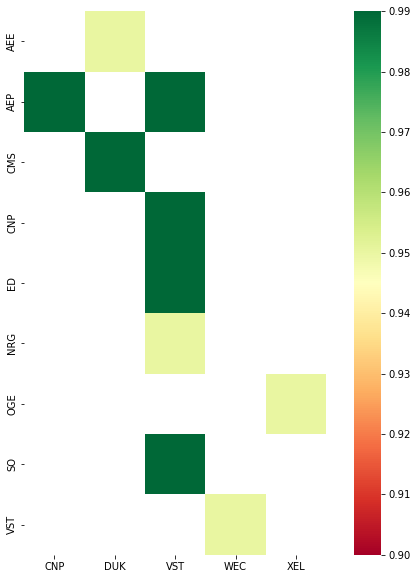

In [993]:
conf_int = 0.95

def green_apply(x):
    green = {True: "background-color: green", False: "color : white"}
    is_color = (x > conf_int).replace(green)
    return is_color

def yellow_apply(x):
    yellow = {True: "background-color: yellow; color : black"}
    is_color = (x <= conf_int).replace(yellow)
    return is_color

def red_apply(x):
    red = {True: "background-color: red"}
    is_color = (x <= 0.90).replace(red)
    return is_color

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_c_adf,
    xticklabels=df_c.columns,
    yticklabels=df_c.index,
    cmap="RdYlGn",
    #mask=(df_c_adf < conf_int),
    square=True,
    vmin=0.90,
    vmax=0.99
)
df_c_adf.style.format(precision=2)\
.apply(green_apply)\
.apply(yellow_apply)\
.apply(red_apply)

Heatmap PP

,CNP,DUK,VST,WEC,XEL
AEE,nan,0.90,nan,nan,nan
AEP,0.95,nan,0.99,nan,nan
CMS,nan,0.95,nan,nan,nan
CNP,nan,nan,0.99,nan,nan
ED,nan,nan,0.99,nan,nan
NRG,nan,nan,0.95,nan,nan
OGE,nan,nan,nan,nan,0.95
SO,nan,nan,0.99,nan,nan
VST,nan,nan,nan,0.99,nan


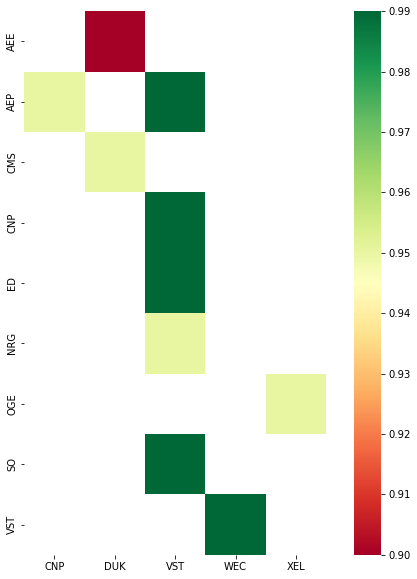

In [994]:
conf_int = 0.95

def green_apply(x):
    green = {True: "background-color: green", False: "color : white"}
    is_color = (x > conf_int).replace(green)
    return is_color

def yellow_apply(x):
    yellow = {True: "background-color: yellow; color : black"}
    is_color = (x <= conf_int).replace(yellow)
    return is_color

def red_apply(x):
    red = {True: "background-color: red"}
    is_color = (x <= 0.90).replace(red)
    return is_color

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_c_pp,
    xticklabels=df_p.columns,
    yticklabels=df_p.index,
    cmap="RdYlGn",
    #mask=(df_c_adf < conf_int),
    square=True,
    vmin=0.90,
    vmax=0.99
)
df_c_pp.style.format(precision=2)\
.apply(green_apply)\
.apply(yellow_apply)\
.apply(red_apply)

#### DROP PAIRS

Drop all %90 conf int values

In [996]:
# check for %90 conf intervals
mask_90 = df_c.isin([0.90])
mask_90_pp = df_c_pp.isin([0.90])
mask_90_adf = df_c_adf.isin([0.90])

# get col names
cols= mask_90.any()
cols_pp = mask_90_pp.any()
cols_adf= mask_90_adf.any()
columns = list(cols[cols == True].index)
columns_pp = list(cols_pp[cols_pp == True].index)
columns_adf = list(cols_adf[cols_adf == True].index)

drop_pairs_list= []

# get rows
for col in columns:
    rows = list(mask_90[col][mask_90[col] == True].index)
    for row in rows:
        drop_pairs_list.append((row, col))

for col in columns_adf:
    rows = list(mask_90_adf[col][mask_90_adf[col] == True].index)
    for row in rows:
        drop_pairs_list.append((row, col))

for col in columns_pp:
    rows = list(mask_90_pp[col][mask_90_pp[col] == True].index)
    for row in rows:
        drop_pairs_list.append((row, col))
        
print("dropped pairs:")
drop_pairs_list = list(set(drop_pairs_list))
print(set(drop_pairs_list))

new_pairs_list = list(set(pairs_list) - set(drop_pairs_list))

print(f"remaining {len(new_pairs_list)} pairs from {df_c.count().sum()}")
list(new_pairs_list)

dropped pairs:
{('AEE', 'DUK'), ('OGE', 'XEL')}
remaining 8 pairs from 10


[('CMS', 'DUK'),
 ('CNP', 'VST'),
 ('VST', 'WEC'),
 ('NRG', 'VST'),
 ('SO', 'VST'),
 ('AEP', 'VST'),
 ('ED', 'VST'),
 ('AEP', 'CNP')]

In [997]:
pairs_final ={}
dropped_final ={}

print("selected: ")
for i in range(len(new_pairs_list)):
    # print pair equation
    pairs_final[new_pairs_list[i]] = hedges[new_pairs_list[i]]
    print(f"EQUATION: {new_pairs_list[i][1]}={hedges[new_pairs_list[i]]}*{new_pairs_list[i][0]}")

print("dropped: ")
for i in range(len(drop_pairs_list)):
    dropped_final[drop_pairs_list[i]] = hedges[drop_pairs_list[i]]
    print(f"EQUATION: {drop_pairs_list[i][1]}={hedges[drop_pairs_list[i]]}*{drop_pairs_list[i][0]}")

selected: 
EQUATION: DUK=1.6*CMS
EQUATION: VST=0.78*CNP
EQUATION: WEC=4.17*VST
EQUATION: VST=0.59*NRG
EQUATION: VST=0.32*SO
EQUATION: VST=0.25*AEP
EQUATION: VST=0.25*ED
EQUATION: CNP=0.31*AEP
dropped: 
EQUATION: DUK=1.17*AEE
EQUATION: XEL=1.8*OGE


Save to file to be used for the next step

In [998]:
with open('pairs_final.pkl', 'wb') as f:
    pickle.dump(pairs_final, f)
with open('pairs_dropped.pkl', 'wb') as f:
    pickle.dump(dropped_final, f)

#### Exercise
Drop if a pair has more than one %90 conf. out of 3 tests; i.e 2 or more %95 or %99 remains

In [1000]:
# check for %90 conf intervals
mask_90 = df_c.isin([0.90])
mask_90_pp = df_c_pp.isin([0.90])
mask_90_adf = df_c_adf.isin([0.90])

# get col names
cols= mask_90.any()
cols_pp = mask_90_pp.any()
cols_adf= mask_90_adf.any()
columns = list(cols[cols == True].index)
columns_pp = list(cols_pp[cols_pp == True].index)
columns_adf = list(cols_adf[cols_adf == True].index)

drop_pairs_1= []
drop_pairs_2= []
drop_pairs_3= []

# get rows
for col in columns:
    rows = list(mask_90[col][mask_90[col] == True].index)
    for row in rows:
        drop_pairs_1.append((row, col))

for col in columns_adf:
    rows = list(mask_90_adf[col][mask_90_adf[col] == True].index)
    for row in rows:
        drop_pairs_2.append((row, col))

for col in columns_pp:
    rows = list(mask_90_pp[col][mask_90_pp[col] == True].index)
    for row in rows:
        drop_pairs_3.append((row, col))
        
drop_set = (set(drop_pairs_1) & set(drop_pairs_2)) | (set(drop_pairs_1) & set(drop_pairs_3)) | (set(drop_pairs_2) & set(drop_pairs_3))
                                                                                                  
print("dropped pairs:")
print(set(drop_set))

new_pairs_list = set(pairs_list) - set(drop_set)

print(f"remaining {len(new_pairs_list)} pairs from {df_c.count().sum()}")
list(new_pairs_list)

dropped pairs:
set()
remaining 10 pairs from 10


[('CMS', 'DUK'),
 ('CNP', 'VST'),
 ('VST', 'WEC'),
 ('OGE', 'XEL'),
 ('NRG', 'VST'),
 ('SO', 'VST'),
 ('AEP', 'VST'),
 ('ED', 'VST'),
 ('AEE', 'DUK'),
 ('AEP', 'CNP')]

#### Exercize
Drop based on conf. int. difference

In [1002]:
# let's eliminate the pairs if any of its test result drops to %90

# keep green from %95 to %99
def green_apply(x):
    color = {True: "background-color: green", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color
# keep yellow (from %99 to %95)
def yellow_apply(x):
    color = {True: "background-color: yellow; color : black"}
    is_color = (x <= -0.04).replace(color)
    return is_color
# drop red (from %99-%95 to %90)
def red_apply(x):
    color = {True: "background-color: red"}
    is_color = (x <= -0.05).replace(color)
    return is_color

df_diff_adf = df_c_adf.subtract(df_c).round(2)
df_diff_adf = df_diff_adf.replace(0, np.nan)

df_diff_pp = df_c_pp.subtract(df_c).round(2)
df_diff_pp = df_diff_pp.replace(0, np.nan)

display(df_diff_adf.style.format(precision=2)\
        .apply(green_apply)\
        .apply(yellow_apply)\
        .apply(red_apply))

display(df_diff_pp.style.format(precision=2)\
        .apply(green_apply)\
        .apply(yellow_apply)\
        .apply(red_apply))

x_list = df_c.index.tolist()
y_list = df_c.columns.tolist()

drop_pairs_list = []

for i in range(len(x_list)):
    for j in range(len(y_list)):
        # print(x_list[i] + "-" + y_list[j])
        if df_diff_adf.iloc[i,j]< -0.04:  # eliminate id drops to %90
            drop_pairs_list.append((x_list[i], y_list[j]))

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_diff_pp.iloc[i,j]< -0.04:  # eliminate id drops to %90
            drop_pairs_list.append((x_list[i], y_list[j]))
                      
print("dropped pairs:")
print(drop_pairs_list)

new_pairs_list = set(pairs_list) - set(drop_pairs_list)

print(f"remaining {len(new_pairs_list)} pairs from {df_c.count().sum()}")
list(new_pairs_list)

,CNP,DUK,VST,WEC,XEL
AEE,nan,nan,nan,nan,nan
AEP,0.04,nan,0.04,nan,nan
CMS,nan,nan,nan,nan,nan
CNP,nan,nan,0.04,nan,nan
ED,nan,nan,nan,nan,nan
NRG,nan,nan,nan,nan,nan
OGE,nan,nan,nan,nan,0.05
SO,nan,nan,0.04,nan,nan
VST,nan,nan,nan,nan,nan


,CNP,DUK,VST,WEC,XEL
AEE,nan,-0.05,nan,nan,nan
AEP,nan,nan,0.04,nan,nan
CMS,nan,-0.04,nan,nan,nan
CNP,nan,nan,0.04,nan,nan
ED,nan,nan,nan,nan,nan
NRG,nan,nan,nan,nan,nan
OGE,nan,nan,nan,nan,0.05
SO,nan,nan,0.04,nan,nan
VST,nan,nan,nan,0.04,nan


dropped pairs:
[('AEE', 'DUK')]
remaining 9 pairs from 10


[('CMS', 'DUK'),
 ('CNP', 'VST'),
 ('VST', 'WEC'),
 ('OGE', 'XEL'),
 ('NRG', 'VST'),
 ('SO', 'VST'),
 ('AEP', 'VST'),
 ('ED', 'VST'),
 ('AEP', 'CNP')]

#### Exercise
Show unique tickers in the list of selected pairs

In [1004]:
import itertools
chain = itertools.chain(*new_pairs_list)
new_tickers = set(chain)
print(f"total {len(set(new_tickers))} tickers")
new_tickers

total 11 tickers


{'AEP', 'CMS', 'CNP', 'DUK', 'ED', 'NRG', 'OGE', 'SO', 'VST', 'WEC', 'XEL'}